In [1]:
import pandas as pd
import torch
import re
import nltk
from nltk.tokenize import word_tokenize
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import random
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [6]:
from model import EmbeddingTaskDataset, LSTMClassifier
import torch.nn.functional as F


In [7]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
train_data = '/dataset/train.csv'
test_data = '/dataset/test.csv'

df_train = pd.read_csv(train_data)
df_test = pd.read_csv(test_data)


In [ ]:
# df_train["Class Index"]

In [ ]:
# for i in df_train["Class Index"]:
#     if i==0:
#         print(i)

In [10]:
df_train.head()


,Class Index,Description
0,3,"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Reuters - Private investment firm Carlyle Grou...
2,3,Reuters - Soaring crude prices plus worries\ab...
3,3,Reuters - Authorities have halted oil export\f...
4,3,"AFP - Tearaway world oil prices, toppling reco..."


In [11]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    tokens = word_tokenize(text)
    return ['<START>'] + tokens + ['<END>']


In [12]:
def build_vocab(corpus):
    vocab = set()
    for doc in corpus:
        for word in doc:
            vocab.add(word)
    vocab_index = {word: i for i, word in enumerate(vocab)}
    return vocab_index


In [13]:
train_data_description = df_train["Description"].tolist()[:20000]
train_data_description = [preprocess_text(desc) for desc in train_data_description]

test_data_description = df_test["Description"].tolist()
test_data_description = [preprocess_text(desc) for desc in test_data_description]


In [14]:
vocab_index = build_vocab(train_data_description)

In [15]:
def generate_skipgrams(sentence, window_size):
    pairs = []
    for i, target_word in enumerate(sentence):
        context_indices = list(range(max(0, i - window_size), i)) + list(range(i+1, min(len(sentence), i + window_size + 1)))
        for context_word in context_indices:
            pairs.append((target_word, sentence[context_word]))

    return pairs

In [16]:
class SkipGramDataset(Dataset):
    def __init__(self, data_indices, window_size=5):
        self.data = []
        for sentence in data_indices:
            self.data.extend(generate_skipgrams(sentence, window_size))
    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

In [17]:
class Word2Vec_Embeddings(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Word2Vec_Embeddings, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.embeddings = nn.Embedding(vocab_size, embedding_dim).to(self.device)
        self.out_embeddings = nn.Embedding(vocab_size, embedding_dim).to(self.device)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

    def forward(self, target_word, context_word, negative_words):
        target_embed = self.embeddings(target_word)
        context_embed = self.out_embeddings(context_word)
        neg_embed = self.out_embeddings(negative_words)
        positive_score = torch.sum(torch.mul(target_embed, context_embed), dim=1)
        negative_score = torch.sum(torch.mul(target_embed.unsqueeze(1), neg_embed), dim=2)
        return positive_score, negative_score

    def train(self, train_data_indices, num_epochs=10, batch_size=128, learning_rate=0.001, negative_samples=5, window = 5):
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        train_dataset = SkipGramDataset(train_data_indices, window)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        for epoch in range(num_epochs):
            total_loss = 0
            for target_word, context_word in train_loader:
                target_word, context_word = target_word.to(self.device), context_word.to(self.device)
                negative_words = torch.randint(0, self.vocab_size, (context_word.size(0), negative_samples), device=self.device)  # Ensure negative_words is on the correct device
                positive_score, negative_score = self(target_word, context_word, negative_words)

                positive_score = positive_score.view(-1, 1)
                negative_score = negative_score.view(-1, 1)

                targets = torch.cat([torch.ones_like(positive_score), torch.zeros_like(negative_score)], dim=0)
                outputs = torch.cat([positive_score, negative_score], dim=0)

                loss = criterion(outputs, targets)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')

    def get_embeddings(self, saveFlag, vocab_index):
        embeddings = self.embeddings.weight.data.cpu().numpy()
        embeddings = self.normalize_embeddings(embeddings)
        self.word_vectors_dict = {word: embeddings[index] for word, index in vocab_index.items()}

        if saveFlag == 1:
            self.save_embeddings()

        return self.word_vectors_dict

    def normalize_embeddings(self, embeddings):
        norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
        normalized_embeddings = embeddings / norms
        return normalized_embeddings

    def save_embeddings(self):
        torch.save(self.embeddings.state_dict(), 'skip-gram-word-vectors.pt')

    def load_embeddings(self, embeddings_path):
        self.embeddings.load_state_dict(torch.load(embeddings_path))


In [18]:
embedding_dim = 100
save_flag = 1
window = 5

In [19]:
train_data_indices = [[vocab_index[word] for word in doc] for doc in train_data_description]

w2v = Word2Vec_Embeddings(len(vocab_index), embedding_dim)
w2v.train(train_data_indices, num_epochs=10, batch_size=128, learning_rate=0.001, negative_samples=5, window=5)


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [21]:
labels = df_train["Class Index"].tolist()[:20000]

labels_test = df_test["Class Index"].tolist()

word_vectors_dict_w2v = w2v.get_embeddings(0, vocab_index)


In [ ]:
w2v.save_embeddings()

In [22]:
input_dim = len(vocab_index)
embedding_dim = 100
hidden_dim = 128
output_dim = df_train["Class Index"].nunique()
batch_size = 128
num_epochs = 10

In [ ]:
word_vectors_word2vec = np.array(list(word_vectors_dict_w2v.values()))
word_vectors_w2v_tensor = torch.tensor(word_vectors_word2vec, dtype=torch.float32)

In [23]:
train_dataset = EmbeddingTaskDataset(train_data_description, vocab_index, labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)

test_dataset = EmbeddingTaskDataset(test_data_description, vocab_index, labels_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=test_dataset.collate_fn)


In [ ]:
model = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, word_vectors_w2v_tensor)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = model.to(device)

In [ ]:
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_loader:
        optimizer.zero_grad()
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

Epoch 1, Loss: 1.1698574583241894
Epoch 2, Loss: 0.8138341451906095
Epoch 3, Loss: 0.7239806492617176
Epoch 4, Loss: 0.6844812825227239
Epoch 5, Loss: 0.6658239349438126
Epoch 6, Loss: 0.6519742023413349
Epoch 7, Loss: 0.6445229414162362
Epoch 8, Loss: 0.6376351440788075
Epoch 9, Loss: 0.6326611565936143
Epoch 10, Loss: 0.6272061541201962


In [ ]:
model.save_model("skip-gram-classification-model.pt")

## Test Metrics

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
model.eval()

all_labels = []
all_predictions = []

model.to(device)

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        predicted = model.predict(texts)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')
f1_macro = f1_score(all_labels, all_predictions, average='macro')

print(f'Accuracy on test data: {accuracy * 100}')
print(f'Precision on test data: {precision * 100}')
print(f'Recall on test data: {recall * 100}')
print(f'F1 micro score on test data: {f1_micro * 100}')
print(f'F1 macro score on test data: {f1_macro * 100}')


Accuracy on test data: 83.60526315789474
Precision on test data: 83.68602527507412
Recall on test data: 83.60526315789474
F1 micro score on test data: 83.60526315789474
F1 macro score on test data: 83.60526315789474


## Confusion Matrix - Test Set

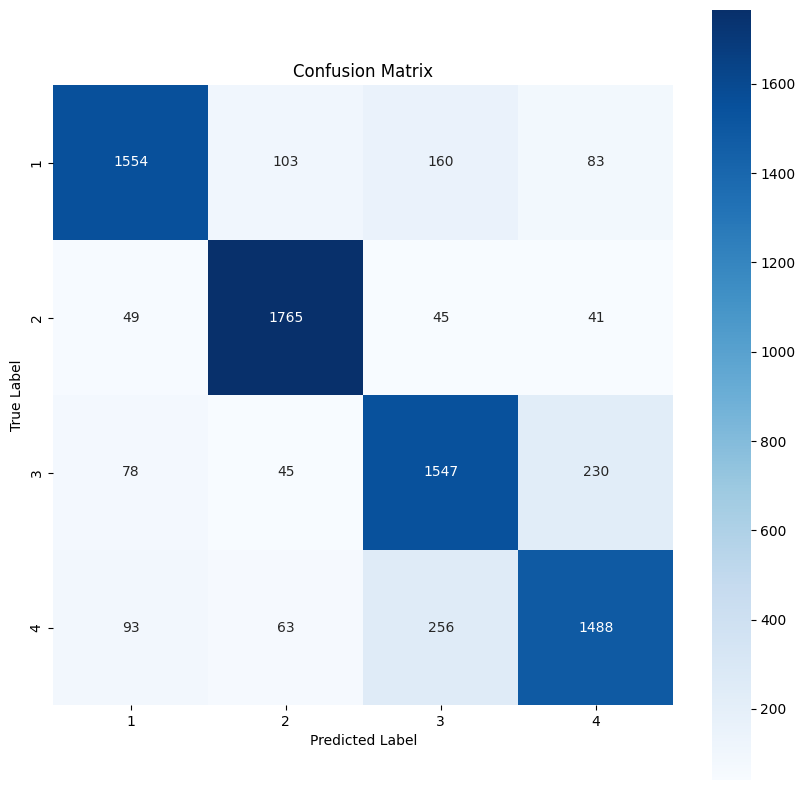

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)
class_names = [1, 2, 3, 4]

max_value = cm.max()

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, square=True, fmt='d', cmap='Blues', vmax=max_value,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Train Metrics

In [ ]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad():
    for texts, labels in train_loader:
        texts = texts.to(device)
        labels = labels.to(device)

        predicted = model.predict(texts)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1_micro = f1_score(all_labels, all_predictions, average='micro')
f1_macro = f1_score(all_labels, all_predictions, average='micro')

print(f'Accuracy on test data: {accuracy * 100}')
print(f'Precision on test data: {precision * 100}')
print(f'Recall on test data: {recall * 100}')
print(f'F1 micro score on test data: {f1_micro * 100}')
print(f'F1 macro score on test data: {f1_macro * 100}')


Accuracy on test data: 84.59
Precision on test data: 84.51202052032369
Recall on test data: 84.62414315913979
F1 micro score on test data: 84.59
F1 macro score on test data: 84.59


## Confusion Matrix - Train Set

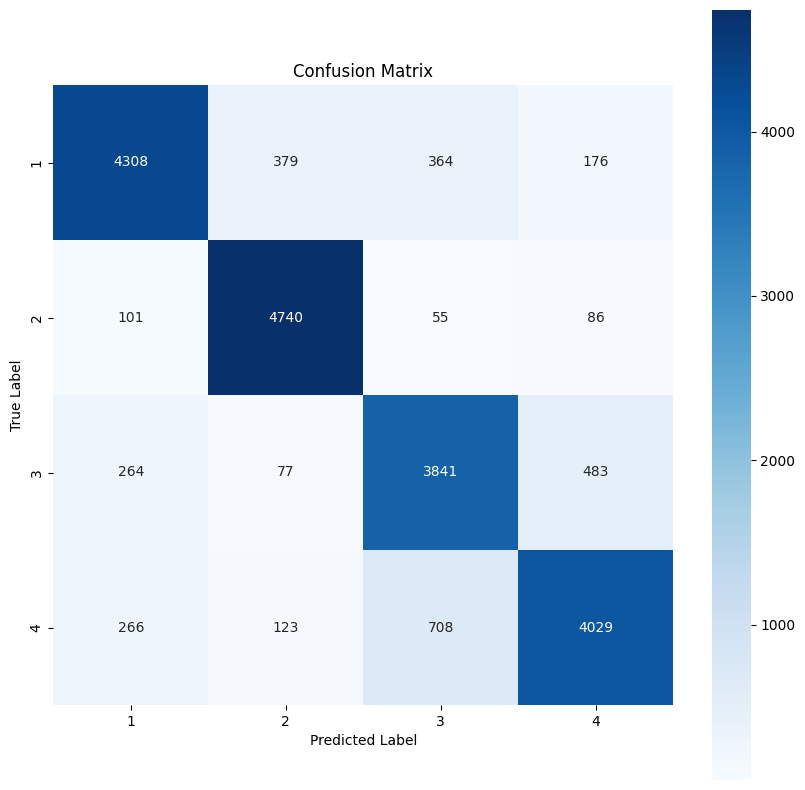

In [ ]:
cm = confusion_matrix(all_labels, all_predictions)
class_names = [1, 2, 3, 4]

max_value = cm.max()

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, square=True, fmt='d', cmap='Blues', vmax=max_value,
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Hyper Parameter Tuning

In [24]:
window_sizes = [1, 2, 3, 4, 5]
model_performance = []

In [25]:
input_dim = len(vocab_index)
embedding_dim = 100
hidden_dim = 128
output_dim = df_train["Class Index"].nunique()
batch_size = 128
num_epochs = 10

In [26]:
for window_size in window_sizes:
    print("Window Size: ", window_size)
    print()
    w2v = Word2Vec_Embeddings(len(vocab_index), embedding_dim)
    w2v.train(train_data_indices, num_epochs=10, batch_size=128, learning_rate=0.001, negative_samples=5, window=window_size)

    word_vectors_dict_w2v = w2v.get_embeddings(0, vocab_index)
    word_vectors_word2vec = np.array(list(word_vectors_dict_w2v.values()))
    word_vectors_w2v_tensor = torch.tensor(word_vectors_word2vec, dtype=torch.float32)

    model = LSTMClassifier(input_dim, embedding_dim, hidden_dim, output_dim, word_vectors_w2v_tensor)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    model = model.to(device)

    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

    model.eval()

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for texts, labels in train_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            predicted = model.predict(texts)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1_micro = f1_score(all_labels, all_predictions, average='micro')
    f1_macro = f1_score(all_labels, all_predictions, average='micro')

    filename = f'./W2V_{window_size}.pth'

    model_performance.append({
        'filename': filename,
        'window_size': window_size,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_macro': f1_macro,
        'f1_micro': f1_micro,
    })

    model.save_model(filename)


Window Size:  1

Epoch 1, Loss: 2.6047
Epoch 2, Loss: 1.1251
Epoch 3, Loss: 0.5862
Epoch 4, Loss: 0.4020
Epoch 5, Loss: 0.3107
Epoch 6, Loss: 0.2538
Epoch 7, Loss: 0.2136
Epoch 8, Loss: 0.1845
Epoch 9, Loss: 0.1619
Epoch 10, Loss: 0.1442
Epoch 1, Loss: 1.3306665914073872
Epoch 2, Loss: 1.0907813481464508
Epoch 3, Loss: 0.9716103904566188
Epoch 4, Loss: 0.9166096441305367
Epoch 5, Loss: 0.88056298198214
Epoch 6, Loss: 0.8604551356309539
Epoch 7, Loss: 0.8437466423982268
Epoch 8, Loss: 0.8323237641601805
Epoch 9, Loss: 0.8216863471990937
Epoch 10, Loss: 0.8146197127688463
Window Size:  2

Epoch 1, Loss: 1.9059
Epoch 2, Loss: 0.5436
Epoch 3, Loss: 0.3381
Epoch 4, Loss: 0.2598
Epoch 5, Loss: 0.2155
Epoch 6, Loss: 0.1877
Epoch 7, Loss: 0.1691
Epoch 8, Loss: 0.1559
Epoch 9, Loss: 0.1464
Epoch 10, Loss: 0.1393
Epoch 1, Loss: 1.2168400481248358
Epoch 2, Loss: 0.887606841743372
Epoch 3, Loss: 0.7941920802851391
Epoch 4, Loss: 0.753178650786163
Epoch 5, Loss: 0.7261139651772323
Epoch 6, Loss: 0.

In [27]:
model_performance

[{'filename': './W2V_1.pth',
  'window_size': 1,
  'accuracy': 0.73585,
  'precision': 0.74429194088856,
  'recall': 0.7373988587941094,
  'f1_macro': 0.73585,
  'f1_micro': 0.73585},
 {'filename': './W2V_2.pth',
  'window_size': 2,
  'accuracy': 0.82055,
  'precision': 0.8205959926875066,
  'recall': 0.819338511001692,
  'f1_macro': 0.82055,
  'f1_micro': 0.82055},
 {'filename': './W2V_3.pth',
  'window_size': 3,
  'accuracy': 0.8301,
  'precision': 0.8287185488436077,
  'recall': 0.8288884237824561,
  'f1_macro': 0.8301,
  'f1_micro': 0.8301},
 {'filename': './W2V_4.pth',
  'window_size': 4,
  'accuracy': 0.84225,
  'precision': 0.8427273402289694,
  'recall': 0.840700379990641,
  'f1_macro': 0.84225,
  'f1_micro': 0.84225},
 {'filename': './W2V_5.pth',
  'window_size': 5,
  'accuracy': 0.8446,
  'precision': 0.8430850356721621,
  'recall': 0.8444638766433025,
  'f1_macro': 0.8446,
  'f1_micro': 0.8446}]